# Building a ConvNet

In this section we'll build and apply a conv net to the mnist dataset.  The layers here are loosely based off of the ConvNext architecture.  Why?  Because we're getting into LLM's soon, and this ConvNet uses LLM features.  ConvNext is an update to the ResNet architecture that outperforms it.

[ConvNext](https://arxiv.org/abs/2201.03545)


The dataset here is CIFAR-10 - slightly harder than MNIST but still relatively easy and computationally tractable.

In [1]:
import torch, torchvision
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    download=False,
    # root="data",
    # download=True,
    train=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    download=False,
    # root="data",
    # download=True,
    train=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    num_workers=2)

/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [71]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


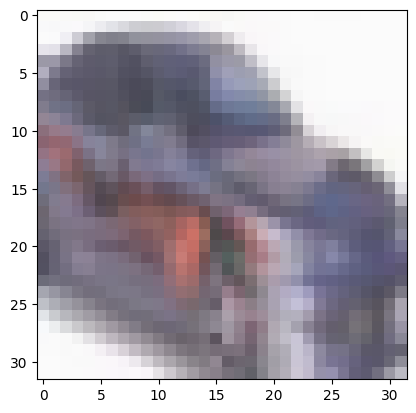

In [3]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [4]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [5]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )

    def forward(self, inputs):


        return self.downsample(self.norm(inputs))



class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels,
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels,
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]



        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [6]:
model = Classifier(32, 4, 4).to(device=dev)

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [7]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()

    loss /= num_batches
    correct /= (size*batch_size)

    accuracy = 100*correct
    return accuracy, loss

In [8]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

        progress_bar.update()

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

In [10]:
from tqdm import tqdm

train_acc_hist = []
val_acc_hist = []
train_loss_hist = []
val_loss_hist = []

epochs = 20
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training & validation loss & accuracy
    # for training data - only once every 5 epochs (takes a while)
    # if j % 5 == 0:
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
        train_acc_hist.append(acc)
        train_loss_hist.append(loss)
    
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        val_acc_hist.append(acc_val)
        val_loss_hist.append(loss_val)

Validate (train) Epoch 0: 100%|██████████| 313/313 [00:08<00:00, 35.36it/s]


Epoch 0: training loss: 2.077, accuracy: 22.943


Validate Epoch 0: 100%|██████████| 79/79 [00:02<00:00, 33.87it/s]


Epoch 0: validation loss: 2.080, accuracy: 23.081


Validate (train) Epoch 1: 100%|██████████| 313/313 [00:08<00:00, 35.12it/s]


Epoch 1: training loss: 1.961, accuracy: 28.454


Validate Epoch 1: 100%|██████████| 79/79 [00:02<00:00, 34.29it/s]


Epoch 1: validation loss: 1.956, accuracy: 28.461


Validate (train) Epoch 2: 100%|██████████| 313/313 [00:08<00:00, 35.13it/s]


Epoch 2: training loss: 1.876, accuracy: 32.578


Validate Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 34.45it/s]


Epoch 2: validation loss: 1.876, accuracy: 32.605


Validate (train) Epoch 3: 100%|██████████| 313/313 [00:08<00:00, 35.32it/s]


Epoch 3: training loss: 1.839, accuracy: 33.831


Validate Epoch 3: 100%|██████████| 79/79 [00:02<00:00, 34.25it/s]


Epoch 3: validation loss: 1.850, accuracy: 33.089


Validate (train) Epoch 4: 100%|██████████| 313/313 [00:08<00:00, 34.92it/s]


Epoch 4: training loss: 1.788, accuracy: 34.520


Validate Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 33.95it/s]


Epoch 4: validation loss: 1.793, accuracy: 34.642


Validate (train) Epoch 5: 100%|██████████| 313/313 [00:08<00:00, 35.27it/s]


Epoch 5: training loss: 1.677, accuracy: 40.031


Validate Epoch 5: 100%|██████████| 79/79 [00:02<00:00, 34.50it/s]


Epoch 5: validation loss: 1.669, accuracy: 40.150


Validate (train) Epoch 6: 100%|██████████| 313/313 [00:08<00:00, 35.19it/s]


Epoch 6: training loss: 1.709, accuracy: 38.736


Validate Epoch 6: 100%|██████████| 79/79 [00:02<00:00, 34.50it/s]


Epoch 6: validation loss: 1.717, accuracy: 37.401


Validate (train) Epoch 7: 100%|██████████| 313/313 [00:08<00:00, 35.12it/s]


Epoch 7: training loss: 1.604, accuracy: 42.564


Validate Epoch 7: 100%|██████████| 79/79 [00:02<00:00, 34.50it/s]


Epoch 7: validation loss: 1.602, accuracy: 41.772


Validate (train) Epoch 8: 100%|██████████| 313/313 [00:08<00:00, 35.47it/s]


Epoch 8: training loss: 1.614, accuracy: 42.183


Validate Epoch 8: 100%|██████████| 79/79 [00:02<00:00, 34.37it/s]


Epoch 8: validation loss: 1.606, accuracy: 41.505


Validate (train) Epoch 9: 100%|██████████| 313/313 [00:08<00:00, 35.33it/s]


Epoch 9: training loss: 1.581, accuracy: 42.839


Validate Epoch 9: 100%|██████████| 79/79 [00:02<00:00, 34.50it/s]


Epoch 9: validation loss: 1.584, accuracy: 42.603


Validate (train) Epoch 10: 100%|██████████| 313/313 [00:08<00:00, 35.16it/s]


Epoch 10: training loss: 1.629, accuracy: 41.871


Validate Epoch 10: 100%|██████████| 79/79 [00:02<00:00, 33.64it/s]


Epoch 10: validation loss: 1.629, accuracy: 41.911


Validate (train) Epoch 11: 100%|██████████| 313/313 [00:08<00:00, 34.91it/s]


Epoch 11: training loss: 1.561, accuracy: 44.833


Validate Epoch 11: 100%|██████████| 79/79 [00:02<00:00, 34.38it/s]


Epoch 11: validation loss: 1.560, accuracy: 44.353


Validate (train) Epoch 12: 100%|██████████| 313/313 [00:08<00:00, 35.15it/s]


Epoch 12: training loss: 1.647, accuracy: 41.678


Validate Epoch 12: 100%|██████████| 79/79 [00:02<00:00, 34.29it/s]


Epoch 12: validation loss: 1.658, accuracy: 41.110


Validate (train) Epoch 13: 100%|██████████| 313/313 [00:09<00:00, 34.17it/s]


Epoch 13: training loss: 1.507, accuracy: 46.700


Validate Epoch 13: 100%|██████████| 79/79 [00:02<00:00, 33.97it/s]


Epoch 13: validation loss: 1.514, accuracy: 45.441


Validate (train) Epoch 14: 100%|██████████| 313/313 [00:08<00:00, 35.53it/s]


Epoch 14: training loss: 1.483, accuracy: 46.353


Validate Epoch 14: 100%|██████████| 79/79 [00:02<00:00, 34.44it/s]


Epoch 14: validation loss: 1.488, accuracy: 45.322


Validate (train) Epoch 15: 100%|██████████| 313/313 [00:09<00:00, 33.99it/s]


Epoch 15: training loss: 1.424, accuracy: 49.231


Validate Epoch 15: 100%|██████████| 79/79 [00:02<00:00, 34.52it/s]


Epoch 15: validation loss: 1.426, accuracy: 48.912


Validate (train) Epoch 16: 100%|██████████| 313/313 [00:08<00:00, 35.12it/s]


Epoch 16: training loss: 1.468, accuracy: 47.749


Validate Epoch 16: 100%|██████████| 79/79 [00:02<00:00, 33.44it/s]


Epoch 16: validation loss: 1.480, accuracy: 46.410


Validate (train) Epoch 17: 100%|██████████| 313/313 [00:08<00:00, 35.31it/s]


Epoch 17: training loss: 1.429, accuracy: 48.667


Validate Epoch 17: 100%|██████████| 79/79 [00:02<00:00, 34.17it/s]


Epoch 17: validation loss: 1.432, accuracy: 48.032


Validate (train) Epoch 18: 100%|██████████| 313/313 [00:08<00:00, 35.31it/s]


Epoch 18: training loss: 1.415, accuracy: 49.523


Validate Epoch 18: 100%|██████████| 79/79 [00:02<00:00, 34.05it/s]


Epoch 18: validation loss: 1.430, accuracy: 48.477


Validate (train) Epoch 19: 100%|██████████| 313/313 [00:08<00:00, 35.39it/s]


Epoch 19: training loss: 1.401, accuracy: 49.583


Validate Epoch 19: 100%|██████████| 79/79 [00:02<00:00, 33.96it/s]

Epoch 19: validation loss: 1.403, accuracy: 48.625


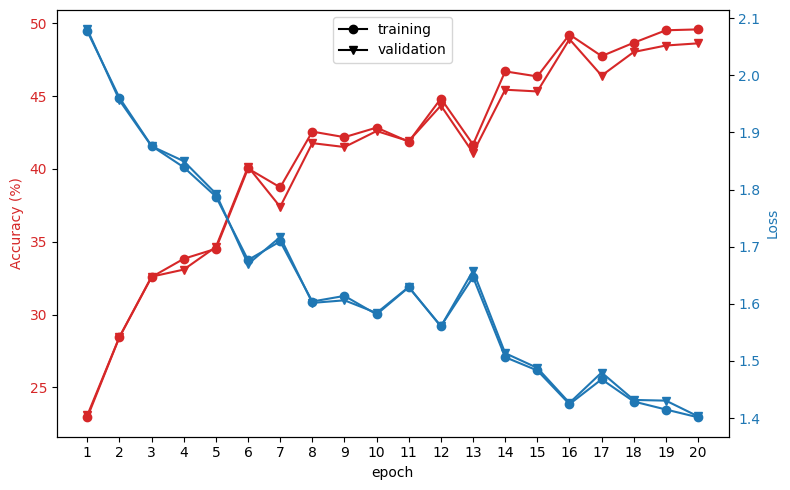

In [75]:
fig, ax1 = plt.subplots(figsize=(8,5))

epochX = range(1,epochs+1)
color = 'tab:red'
ax1.plot(np.nan, np.nan, marker='o', color="k", label="training")
ax1.plot(np.nan, np.nan, marker='v', color="k", label="validation")
ax1.legend(loc="upper center")
ax1.plot(epochX, train_acc_hist, marker='o', color=color)
ax1.plot(epochX, val_acc_hist, marker='v', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('epoch')
ax1.set_ylabel('Accuracy (%)', color=color)
ax1.set_xticks(epochX)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(epochX, train_loss_hist, marker='o', color=color)
ax2.plot(epochX, val_loss_hist, marker='v', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Homework

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.